# Machine Learning: K supercomputer double perovskite dataset

## Part 1: data processing

Welcome to this tutorial! This notebook follows from a lecture given at Cal State LA from the weeks of May 20 to May 24, 2019.

Here is the game plan: We have an Excel file containing the chemical formulae of double perovskite materials, as well as their bandgaps, calculated via an accurate method (HSE hybrid functional with spin-orbit coupling).

Each compound is a so-called 'double perovskite', with a chemical composition of the form $A_2 BB' X_6$, where $A$ is either a polyatomic ion or an alkali metal, $B$ is some atom, and $X$ is a halogen. 

We will use regular expressions to extract the specific atoms that make up the $A$, $B$, $B'$, and $X$ sites for each double perovskite, and generate atomic features. Then, we will use a machine learning algorithm to predict the band gap using atomic features.

The first step is to import `numpy` (for numerical operations), `pandas` (for handling data frames), and `pymatgen`, which contains atomic data.

If you cannot import `pymatgen`, please install it first by typing `conda install -c matsci pymatgen`.

In [1]:
import numpy as np
import pandas as pd
from pymatgen.core.periodic_table import Element

Let's read in the Excel file into a data frame:

In [2]:
df = pd.read_excel('jz7b02203_si_002.xlsx')

And then save it to a `pkl` file. This file will be a binary file, and considerably faster to load than the `xlsx` file, if you wish to re-run this notebook again.

In [3]:
df.to_pickle('df.pkl')

Let us view some entries in this data frame. Use `df.head()` to see the first five entries. We can see some compounds of the form $A_4 B_4 X_{12}$:

In [4]:
df.head()

,System,TotEne_PBE_Smear,TotEne_PBE_Nonsmear,TotEne_SOPBE,TotEne_SOHSE_Approx1,TotEne_SOHSE_Approx2,TotEne_SOHSE_Approx,DirectGap_PBE,DirectGap_SOPBE,DirectGap_SOHSE_Approx1,...,Ev_SOHSE_Approx1,Ev_SOHSE_Approx2,Ev_SOHSE_Approx,Ec_SOHSE_Approx1,Ec_SOHSE_Approx2,Ec_SOHSE_Approx,Mass_VBM,Mass_CBM,perovskite,nontoxicity
0,C4N4H24Be4I12,-207.385597,-207.384168,NaN,NaN,NaN,NaN,4.307587,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,2.2336,-0.7022,No,Yes
1,C4N4H24B4I12,-210.442946,-210.832772,-212.426721,-291.679667,-291.748642,-291.748642,1.957007,1.829610,3.180325,...,-6.328621,-6.344494,-6.344494,-3.180668,-3.164795,-3.164795,3.3445,-43.1810,No,Yes
2,C4N4H24C4I12,-207.448155,-207.445549,-209.150007,-292.435476,-292.514091,-292.514091,0.769122,0.695907,1.840094,...,-5.889648,-5.890998,-5.890998,-4.049554,-4.048204,-4.048204,2.1819,-0.5658,No,Yes
3,C4N4H24N4I12,-206.031947,-206.276663,-208.090457,-295.760101,-295.822950,-295.822950,1.067985,1.003489,2.382841,...,-6.217354,-6.219469,-6.219469,-3.899306,-3.897190,-3.897190,2.9718,-7.5010,No,Yes
4,C4N4H24Mg4I12,-203.355980,-203.353890,-204.897868,-281.359832,-281.435270,-281.435270,1.774819,1.606697,2.878062,...,-6.118930,-6.129990,-6.129990,-3.240868,-3.229808,-3.229808,1.3698,-0.3258,Yes,Yes


Use `df.tail()` to see the last five entries. It looks like these are of the form $A_4 B_2 B'_2 X_{12}$:

In [5]:
df.tail()

,System,TotEne_PBE_Smear,TotEne_PBE_Nonsmear,TotEne_SOPBE,TotEne_SOHSE_Approx1,TotEne_SOHSE_Approx2,TotEne_SOHSE_Approx,DirectGap_PBE,DirectGap_SOPBE,DirectGap_SOHSE_Approx1,...,Ev_SOHSE_Approx1,Ev_SOHSE_Approx2,Ev_SOHSE_Approx,Ec_SOHSE_Approx1,Ec_SOHSE_Approx2,Ec_SOHSE_Approx,Mass_VBM,Mass_CBM,perovskite,nontoxicity
11020,Cs4Hg2Pb2Cl12,-64.830507,-64.677965,-66.024060,-119.383818,-119.811363,-119.811363,2.128673,2.041891,3.317036,...,-6.493482,-6.604364,-6.604364,-4.078386,-3.967504,-3.967504,0.5089,-0.2990,Yes,No
11021,Cs4Hg2Tl2Cl12,-60.418179,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
11022,Cs4Tl2Bi2Cl12,-71.438912,-71.195789,-72.535615,-124.555184,-124.712130,-124.712130,1.912991,0.815462,2.005946,...,-6.155114,-6.158749,-6.158749,-4.149168,-4.145534,-4.145534,0.2150,-0.3949,Yes,No
11023,Cs4Tl2Pb2Cl12,-69.551930,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No
11024,Cs4Pb2Bi2Cl12,-71.608804,NaN,NaN,NaN,NaN,NaN,0.000000,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Yes,No


We only care about the chemical formulae (`System`) and the bandgap (`LowGap_SOHSE_Approx`).

In `System`, we have the chemical formula of each double perovskite. Although the chemical formula is written as $A_2BB'X_6$, there are two formula units in the unit cell, so it is written as $A_4B_2B'_2X_{12}$ in the Excel file. In some compounds, $B$ and $B'$ are the same element; in these cases, it is written as $A_4 B_4 X_{12}$.

`SO` refers to spin-orbit coupling, `HSE` refers to the hybrid functional (developed by Heyd, Scuseria, and Ernzerhof), and `LowGap` means the minimum of the direct gap and indirect gap.

Thus, let's remove the unnecessary columns:

In [6]:
df = df[['System', 'LowGap_SOHSE_Approx']]

Let us also remove the `NaN` values.

Let us also remove the values for which the band gap is negative (negative values for the band gap do not make physical sense).

In [7]:
# Remove NaN values
df = df.dropna()

# Remove negative band gap values
df = df[df['LowGap_SOHSE_Approx'] >= 0]

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11029d3c8>]],
      dtype=object)

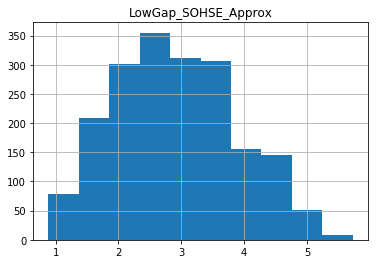

In [8]:
# Make a histogram
%matplotlib inline
df.hist()

Now, we wish to use regular expressions to extract the $A$, $B$, $B'$, and the $X$ sites.

For the $A$ sites, there are three different kinds of ions: methylammonium (written as `C4N4H24`), formamidinium (written as `C4N8H20`), and caesium (written as `Cs4`). Note that there are four of these ions in the unit cell; hence, everything is multiplied by 4.

We can use a regular expresssion to match for any of these three atoms: `C4N4H24|C4N8H20|Cs`.

Using the `pandas.DataFrame.str.extract` method, we can use a regular expression to match `C4N4H24|C4N8H20|Cs`, returning a `Series` object. We need to wrap this in parentheses for `extract` to match the pattern. For `extract` to interpret the string as a regular expression, we prefix an `r` before the string.

For convenience, we will rename the ions to abbreviated names. When the `pandas.DataFrame.replace` method takes in two strings, the first string is the string to replace, and the secon is the string that will be put in in place of the original string. `inplace=True` specifies that we wish to modify the object itself, rather than a copy.

In [9]:
a_sites = df['System'].str.extract(r'(C4N4H24|C4N8H20|Cs4)')

a_sites.replace('C4N4H24', 'MA', inplace=True)
a_sites.replace('C4N8H20', 'FA', inplace=True)
a_sites.replace('Cs4', 'Cs', inplace=True)
a_sites.head()

,0
1,MA
2,MA
3,MA
4,MA
5,MA


Then, we will save this `a_sites` into a column into `df`.

In [10]:
df['A_sites'] = a_sites

Now, we need to get the $B$ site.

The problem is that we need to differentiate the compounds written as $A_4B_2B'_2X_{12}$ (which we will call `true_dbls`) with the compounds written as $A_4B_4X_{12}$ (which we call `false_dbls`).

Our plan is to handle these two cases separately, and then join them into one data frame agai
We can use a method called `pandas.DataFrame.str.contains` which returns a `Series` object containing boolean values, based of a regular expression query, which will check if it is of the form for `true_dbls`. We can then use boolean indexing based off of this `Series`.

What we need to do is see if there is a sequence of alphabetical characters, followed by a `2`, followed by another sequence of alphabetical characters, followed by another `2`. We can check for a group of alphabetical characters by using `[a-zA-Z]`, and we can match for a sequence of characters by using `+`. We can use a lookahead `(?=pattern)` to check if `pattern` is ahead of this group of alphabetical characters. In this case, we'll check if there is a `2`, followed by another `[a-zA-Z]+` and then another `2`.

We will use `.copy()` to avoid modifying the original data frame.

In [11]:
true_dbls = df[df['System'].str.contains(r'[a-zA-Z]+(?=2[a-zA-Z]+2)')].copy()
true_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites
50,C4N4H24Be2Pb2I12,3.190090,MA
52,C4N4H24Be2Hg2I12,3.111010,MA
54,C4N4H24Be2Pt2I12,2.524556,MA
60,C4N4H24Be2Hf2I12,3.055102,MA
61,C4N4H24Be2Ba2I12,4.566838,MA


Then, we will use `extract` to actually find the group of characters that precedes the lookahead.

We will write the appropriate regular expressions to find $B$ and $B'$ sites.

For $B$ site: `([a-zA-Z]+)(?=2[a-zA-Z]+2)` (a group of alphabetical characters; look ahead for `2`, followed by another group of alphabetical characters, followed by another `2`).

For $B'$ site: `([a-zA-Z]+)(?=2[a-zA-Z]+12)` (a group of alphabetical characters; look ahead for `2`, followed by another group of alphabetical characters, followed by `12`).

In [12]:
# match a group of alphabetical chars
# followed by a 2, another group of alphabetical chars,
# and then another 2
b_sites = true_dbls['System'].str.extract(r'([a-zA-Z]+)(?=2[a-zA-Z]+2)')
b_sites
# match a group of alphabetical chars
# followed by a 2, another group of alphabetical chars,
# and then a 12
b_prime_sites = true_dbls['System'].str.extract(r'([a-zA-Z]+)(?=2[a-zA-Z]+12)')
b_prime_sites

true_dbls['B_sites'] = b_sites
true_dbls['B_prime_sites'] = b_prime_sites

true_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites
50,C4N4H24Be2Pb2I12,3.190090,MA,Be,Pb
52,C4N4H24Be2Hg2I12,3.111010,MA,Be,Hg
54,C4N4H24Be2Pt2I12,2.524556,MA,Be,Pt
60,C4N4H24Be2Hf2I12,3.055102,MA,Be,Hf
61,C4N4H24Be2Ba2I12,4.566838,MA,Be,Ba


We can negate the condition for boolean indexing by using a `~`. This will give us the `false_dbls`. Note that here, $B$ and $B'$ are the same.

In [13]:
false_dbls = df[~df['System'].str.contains(r'[a-zA-Z]+(?=2[a-zA-Z]+2)')].copy()

b_sites = false_dbls['System'].str.extract(r'([a-zA-Z]+)(?=4[a-zA-Z]+12)')

false_dbls['B_sites'] = b_sites
false_dbls['B_prime_sites'] = b_sites

false_dbls.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites
1,C4N4H24B4I12,3.179699,MA,B,B
2,C4N4H24C4I12,1.842794,MA,C,C
3,C4N4H24N4I12,2.322279,MA,N,N
4,C4N4H24Mg4I12,2.900182,MA,Mg,Mg
5,C4N4H24Al4I12,2.038116,MA,Al,Al


Concatenate `true_dbls` with `false_dbls` by using `pandas.concat`, and use regular expressions to find a group of characters followed by a `12` (the $X$ site).

In [14]:
df_new = pd.concat([true_dbls, false_dbls], sort=False)

x_sites = df_new['System'].str.extract(r'([a-zA-Z]+)(?=12)')
df_new['X_sites'] = x_sites

df_new.head()

,System,LowGap_SOHSE_Approx,A_sites,B_sites,B_prime_sites,X_sites
50,C4N4H24Be2Pb2I12,3.190090,MA,Be,Pb,I
52,C4N4H24Be2Hg2I12,3.111010,MA,Be,Hg,I
54,C4N4H24Be2Pt2I12,2.524556,MA,Be,Pt,I
60,C4N4H24Be2Hf2I12,3.055102,MA,Be,Hf,I
61,C4N4H24Be2Ba2I12,4.566838,MA,Be,Ba,I


We will now create dictionaries, with the atomic symbol (such as `Cs`) as the key, and the desired property as a value. We do this because `pandas.DataFrame.replace` can take dictionaries. This can help us create columns with the desired properties for each compound.

Create a dictionary of ionic radii using `pymatgen`. `Element.from_Z` creates an `Element` object from atomic number, from which we can extract properties such as the ionic radius. 

For methylammonium and formamidinium, we will use results from a paper by [Kieslich *et al.*](https://pubs.rsc.org/en/content/articlelanding/2014/sc/c4sc02211d#!divAbstract) (*Chem. Sci.* **2014**, *5*, 4712).

In [15]:
IONIC_R_DICT = {Element.from_Z(i).symbol:
                Element.from_Z(i).average_ionic_radius
                for i in range(1, 93)}

# Kieslich et al. Chem. Sci. 2014, 5, 4712
IONIC_R_DICT['MA'] = 2.17
IONIC_R_DICT['FA'] = 2.53

Create similar dictionaries for electronegativity, boiling point and melting point. Note that for electronegativity, `pymatgen` uses the capital letter `X` (this is because electronegativity is sometimes written using the Greek letter $\chi$ 'chi').

In [16]:
# Electronegativity -- 'Chi'
ENEG_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).X for i in range(1, 93)}

BOIL_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).boiling_point
             if Element.from_Z(i).boiling_point
             else 0 for i in range(1, 93)}

MELT_DICT = {Element.from_Z(i).symbol:
             Element.from_Z(i).melting_point
             if type(Element.from_Z(i).melting_point) != str
             else 300. for i in range(1, 93)}

/Users/kawazu/.anaconda3/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:427: UserWarning: No electronegativity for He. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/kawazu/.anaconda3/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:427: UserWarning: No electronegativity for Ne. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)
/Users/kawazu/.anaconda3/lib/python3.7/site-packages/pymatgen/core/periodic_table.py:427: UserWarning: No electronegativity for Ar. Setting to NaN. This has no physical meaning, and is mainly done to avoid errors caused by the code expecting a float.
  % self.symbol)


Read in a file for the Zunger valence radii $R_s$, $R_p$, and $R_d$, with which we can make a dictionary, of which we can generate a column of features.

In [17]:
zvr = pd.read_csv('zungervalenceradius.csv.txt')

RS_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rs'] for i in zvr.index}

RP_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rp'] for i in zvr.index}

RD_DICT = {zvr.loc[i]['Element']:
           zvr.loc[i]['Rd'] for i in zvr.index}

Read in another file for the (first) ionization potentials, and make a dictionary out of this.

In [18]:
ip = pd.read_csv('ion.csv', sep=';',
                 header=None,
                 names=['Z', 'Element',
                        'IP1', 'IP2', 'IP3'])

IP_DICT = {ip.loc[i]['Element']:
           ip.loc[i]['IP1'] for i in ip.index}

Next, we wil make a function `get_quant` that add columns for each feature, modifying `df` inplace. It will take in the `df` we wish to modify, the feature dictionary, the column title, and the kind of site, and use `pandas.DataFrame.replace` to add the desired column of features with the specified title, prefixed by the kind of site.

Note that for every $B$ site features, we use a symmetric representation. The choice of which is $B$ and which $B'$ is simply alphabetical and hence arbitrary, and we wish for the model to see the same features if $B$ and $B'$ are reversed.

Hence, for every $B$ site feature $f_B$ and $B'$ site feature $f_{B'}$, we return the sum $f_B + f_{B'}$ and the absolute difference $|f_B - f_{B'}|$.

In [19]:
# data frame, feature dictionary, title of column, kind of site
# --> modify the data frame inplace

def get_quant(df, feat_dict, title, kind):
    if kind == 'A':
        df['A_' + title] = df['A_sites'].replace(feat_dict)
    elif kind == 'B':
        summ = (df['B_sites'].replace(feat_dict) +
                df['B_prime_sites'].replace(feat_dict))
        dif = np.abs(df['B_sites'].replace(feat_dict) -
                     df['B_prime_sites'].replace(feat_dict))
        df['B_' + title + '_sum'] = summ
        df['B_' + title + '_dif'] = dif
    elif kind == 'X':
        df['X_' + title] = df['X_sites'].replace(feat_dict)       

Then we will call this function `get_quant` on the features we wish to use. For all of these features (except the ionic radius), we cannot use them on the $A$ site, as some of these quantities are not well defined or not available for polyatomic ions.

In [20]:
desired_features = [(IONIC_R_DICT, 'IonicRadius'),
                    (ENEG_DICT, 'Electronegativity'),
                    (BOIL_DICT, 'BoilingPoint'),
                    (MELT_DICT, 'MeltingPoint'),
                    (RS_DICT, 'Rs'),
                    (RP_DICT, 'Rp'),
                    (RD_DICT, 'Rd'),
                    (IP_DICT, 'FirstIonizationPotential')]

for feat_dict, title in desired_features:
    get_quant(df_new, feat_dict, title, 'B')
    get_quant(df_new, feat_dict, title, 'X')

In [21]:
# Generate the atomic radius for the A site

get_quant(df_new, IONIC_R_DICT, 'IonicRadius', 'A')

Finally, we will make one final feature, which is the tolerance factor. Let's make a function `get_tolerance_factor` that does this.

This gives some information as to what kind of crystal structure the perovskite will adopt. For a given perovskite with $A$, $B$, and $X$ sites, the tolerance factor $t$ is given by

$$ t = {R_A + R_X \over \sqrt{2} \cdot (R_B + R_X)} $$

where $R_A$, $R_B$, and $R_X$ are the ionic radii of the $A$, $B$, and $X$, sites, respectively.

Since we have both $B$ and $B'$ sites, we calculate the tolerance factor for $B$ site ($t_B$) and the tolerance factor $B'$ site ($t_{B'}$). Again, we use the same trick from earlier to generate two symmetrized features; $t_B + t_{B'}$ and $|t_B - t_{B'}|$.

In [22]:
# (Ra + Rx) / (np.sqrt(2) * (Rb + Rx))
def get_tolerance_factor(df, title='ToleranceFactor'):
    Ra = df['A_sites'].replace(IONIC_R_DICT)
    Rb = df['B_sites'].replace(IONIC_R_DICT)
    Rbp =  df['B_prime_sites'].replace(IONIC_R_DICT)
    Rx = df['X_sites'].replace(IONIC_R_DICT)
    
    df[title + '_sum'] = (
        (Ra + Rx) / (np.sqrt(2) * (Rb + Rx)) +
        (Ra + Rx) / (np.sqrt(2) * (Rbp + Rx))
    )

    df[title + '_dif'] = np.abs(
        (Ra + Rx) / (np.sqrt(2) * (Rb + Rx)) -
        (Ra + Rx) / (np.sqrt(2) * (Rbp + Rx))
    )

Finally, let's call this function on our data frame.

In [23]:
get_tolerance_factor(df_new)

Let's save our hard work into a `pkl` file. Next we'll try to do machine learning on it on another day.

In [24]:
df_new.to_pickle('df_new.pkl')

Congrats! After all that, we're done ^^